$
\phi(t,r,\theta,\psi)=\sum_{l,m}c_{lm}(t)Y_{lm}(\theta,\psi)
$

$
\partial_t^2 \phi=\Delta \phi
$
is equivalent to

$
\partial_t^2 c_{lm}(t)=-l(l+1)c_{lm}(t)
$

which can be solved by Finite Difference Method (FDM), with the error~(delta_t^2)

$
(c_{lm}(t_{n+1})-2c_{lm}(t_n)+2c_{lm}(t_{n-1}))/(\delta t^2)=-l(l+1)c_{lm}(t_n)
$

$
c_{lm}(t_{n+1})=-l(l+1)c_{lm}(t_n)*\delta t^2+2c_{lm}(t_n)-c_{lm}(t_{n-1})
$
for n>=1,

for n=1, $c_{lm}(t_1)=c_{lm}(t_0)-l(l+1)c_{lm}(t_0)*\delta t^2$

Additionally, I found that the integration for Y_lm with m != 0 is extremely slow. Since the initial condition has a rotational symmetry around z-axis, I'll set all m=0 to speed up the computation

In [1]:
using SphericalHarmonics
using LinearAlgebra
using Plots
using QuadGK


# Define a test function for ϕ(t, θ, ϕ)
function ϕ_ini(θ, ϕ)
    return exp(-θ^2/(2*0.2^2))
end

# Compute spherical harmonic coefficients c_lm(t_0)
function compute_coefficients(l,m)
    integrand(θ, ϕ) = ϕ_ini(θ, ϕ) * conj(SphericalHarmonics.sphericalharmonic(θ, ϕ; l, m)) * sin(θ)
    θ_integral(ϕ) = quadgk(θ -> integrand(θ, ϕ), 0, π)[1]
    c_lm= quadgk(θ_integral, 0, 2π)[1]
    return c_lm
end

# Reconstruct ϕ(t, θ, ϕ) from coefficients c_lm(t)
function reconstruct_phi(c_lm, θ, ϕ,L_max)
    Y=computeYlm(θ, ϕ; lmax=L_max)
    Y_0=Vector{ComplexF64}()
    for l in 0:L_max
        push!(Y_0,Y[(l,0)])
    end
    return dot(c_lm,Y_0)
end

reconstruct_phi (generic function with 1 method)

In [19]:
# Parameters
L_max = 15  # Maximum degree of spherical harmonics
t_ini=0.
t_fin=10.
N_t = 100
delta_t=(t_fin-t_ini)/N_t

# Initialize the coefficients C_{lm}(t_0=0)
c_lm_0=Vector{ComplexF64}()
for l in 0:L_max
#    for m in -l:l
        push!(c_lm_0,compute_coefficients(l,0))
#    end
end

# c_lm being the matrix of coefficients as a function of time
c_lm = zeros(ComplexF64,N_t,length(c_lm_0))
c_lm[1,:]=c_lm_0

16-element Vector{ComplexF64}:
   0.06996036476275512 + 0.0im
   0.11645478493194346 + 0.0im
   0.13885800679219404 + 0.0im
   0.14583728724096343 + 0.0im
   0.14106479302603445 + 0.0im
   0.12785432934364355 + 0.0im
   0.10951056081478268 + 0.0im
   0.08907139560937029 + 0.0im
   0.06900299497214654 + 0.0im
   0.05101678644047881 + 0.0im
   0.03604790869013319 + 0.0im
  0.024367392787082866 + 0.0im
   0.01576992673862311 + 0.0im
   0.00977676194126811 + 0.0im
  0.005809031103062169 + 0.0im
 0.0033091327620997104 + 0.0im

C_{l=15} is already small than the estimated numerical error 0.01, so I choose L_max =15 as the cut off

If we increase L_max without increasing N_t, the solution will not be more accurate

If we decrease L_max, for example we choose L_max=4, the solution will of course becomes inaccurate

In [3]:
# Evolve c_lm(t), m=0, using Finite Difference Method (FDM), with the error~(delta_t^2)~0.01
for i in 2:N_t
    if i==2
#        j=1
        for l in 0:L_max
#            for m in -l:l
                c_lm[i,l+1]=c_lm[i-1,l+1]-l*(l+1)c_lm[i-1,l+1]*delta_t^2
#                j+=1
#            end
        end
    else
#        j=1
        for l in 0:L_max
#            for m in -l:l
                c_lm[i,l+1]=2*c_lm[i-1,l+1]-c_lm[i-2,l+1]-l*(l+1)c_lm[i-1,l+1]*delta_t^2
#                j+=1
#            end
        end
    end
end

In [4]:

# Example usage

# Reconstruct ϕ(t, θ, ϕ) on a grid
θ = range(0, π, length=100)
ϕ = range(0, 2*π, length=100)
ϕ_reconstructed_5 = real([reconstruct_phi(c_lm[50,:], θ_i, ϕ_i,L_max) for θ_i in θ, ϕ_i in ϕ]) #t=5
ϕ_reconstructed_10 = real([reconstruct_phi(c_lm[N_t,:], θ_i, ϕ_i,L_max) for θ_i in θ, ϕ_i in ϕ]) #t=10

# The original function and the reconstructed function
ϕ_original = [ϕ_ini(θ_i, ϕ_i) for θ_i in θ, ϕ_i in ϕ];


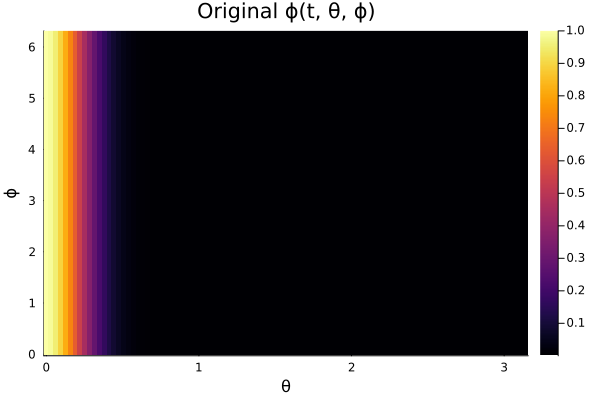

In [25]:
# Plot original function, at t=0
heatmap(θ, ϕ, ϕ_original', xlabel="θ", ylabel="ϕ", title="Original ϕ(t, θ, ϕ)")


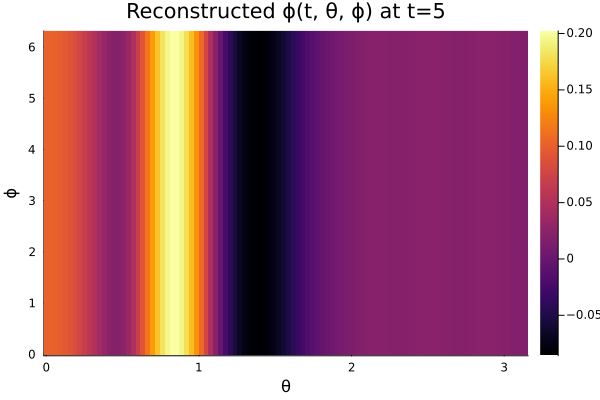

In [26]:
# Plot reconstructed function, at t=5
heatmap(θ, ϕ, ϕ_reconstructed_5', xlabel="θ", ylabel="ϕ", title="Reconstructed ϕ(t, θ, ϕ) at t=5")


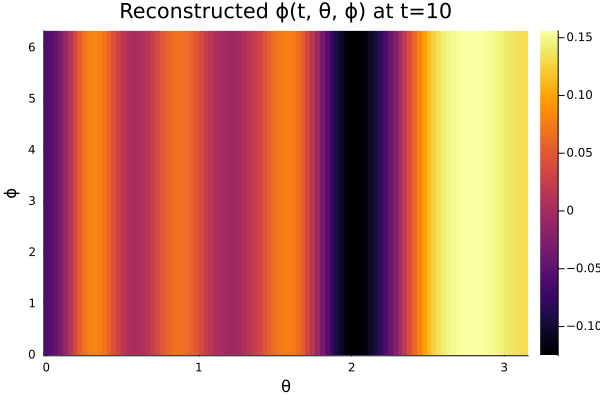

In [27]:
# Plot reconstructed function, at t=10
heatmap(θ, ϕ, ϕ_reconstructed_10', xlabel="θ", ylabel="ϕ", title="Reconstructed ϕ(t, θ, ϕ) at t=10")
